In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, mean_absolute_error

2025-03-24 07:44:10.639026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742782450.660219   94153 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742782450.666637   94153 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742782450.684733   94153 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742782450.684763   94153 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742782450.684765   94153 computation_placer.cc:177] computation placer alr

In [ ]:
# Define the function to load the dataset
def load_data(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path, header=None, skiprows=1)  # Skip the first row if it contains incorrect headers
    
    # Assign column names based on the structure of the file
    data.columns = [
        "Hue", "Value", "Chroma", "r", "g", "b", 
        "L", "A", "B"
    ]
    
    # Inspect the data
    print("First few rows of the dataset:")
    print(data.head())
    print("\nData Info:")
    print(data.info())
    
    return data

# Load the dataset
file_path = "/home/sala/data/equivalent_munsell.csv"  # Replace with the actual path to your dataset
data = load_data(file_path)

First few rows of the dataset:
   Hue  Value  Chroma         r         g         b         L         A  \
0  10B    1.0       1  0.069966  0.102321  0.125645  8.766975 -1.873666   
1  10B    1.0       2  0.047615  0.104012  0.144154  8.752576 -2.435589   
2  10B    1.0       3  0.012557  0.106032  0.164007  8.734874 -3.121113   
3  10B    1.0       4  0.000000  0.108210  0.184417  9.105021 -1.903252   
4  10B    1.0       5  0.000000  0.110270  0.204285  9.653357  0.194611   

           B  
0  -5.355077  
1  -8.942874  
2 -12.765529  
3 -16.018042  
4 -18.828227  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447 entries, 0 to 10446
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hue     10447 non-null  object 
 1   Value   10447 non-null  float64
 2   Chroma  10447 non-null  int64  
 3   r       10447 non-null  float64
 4   g       10447 non-null  float64
 5   b       10447 non-null  float64
 6   L      

In [4]:
# Define the function to clean the dataset
def clean_data(data):
    # Check for non-numeric values in L, A, B columns
    for col in ["L", "A", "B"]:
        non_numeric_values = data[pd.to_numeric(data[col], errors='coerce').isnull()][col]
        if not non_numeric_values.empty:
            print(f"Non-numeric values found in {col}: {non_numeric_values.unique()}")
            data = data[pd.to_numeric(data[col], errors='coerce').notnull()]
    
    # Convert L, A, B columns to numeric
    data["L"] = pd.to_numeric(data["L"], errors='coerce')
    data["A"] = pd.to_numeric(data["A"], errors='coerce')
    data["B"] = pd.to_numeric(data["B"], errors='coerce')
    
    # Drop rows with NaN values in L, A, B columns
    data = data.dropna(subset=["L", "A", "B"])
    
    return data

# Clean the dataset
data = clean_data(data)

In [5]:
# Define the function to preprocess the dataset
def preprocess_data(data):
    # Extract input features (LAB values)
    X = data[["L", "A", "B"]].values.astype(np.float32)
    
    # Normalize L, A, B channels
    X[:, 0] /= 100.0  # Normalize L channel: [0, 100] → [0, 1]
    X[:, 1] = (X[:, 1] + 128) / 255.0  # Normalize A channel: [-128, 127] → [0, 1]
    X[:, 2] = (X[:, 2] + 128) / 255.0  # Normalize B channel: [-128, 127] → [0, 1]
    
    # Extract target labels (Hue, Value, Chroma)
    y_hue = pd.get_dummies(data["Hue"]).values.astype(np.float32)  # One-hot encode Hue
    y_value = data["Value"].values.astype(np.float32).reshape(-1, 1)
    y_chroma = data["Chroma"].values.astype(np.float32).reshape(-1, 1)
    
    return X, y_hue, y_value, y_chroma

# Preprocess the dataset
X, y_hue, y_value, y_chroma = preprocess_data(data)

# Split into training and validation sets
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_hue_train, y_hue_val = y_hue[:split_idx], y_hue[split_idx:]
y_value_train, y_value_val = y_value[:split_idx], y_value[split_idx:]
y_chroma_train, y_chroma_val = y_chroma[:split_idx], y_chroma[split_idx:]

In [6]:
# Define the function to build the model
def build_model(input_shape, num_hues):
    inputs = Input(shape=input_shape)
    
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    hue_output = Dense(num_hues, activation='softmax', name="hue_output")(x)
    value_output = Dense(1, activation='linear', name="value_output")(x)
    chroma_output = Dense(1, activation='linear', name="chroma_output")(x)
    
    return Model(inputs=inputs, outputs=[hue_output, value_output, chroma_output])

# Build the model
num_hues = y_hue.shape[1]  # Number of unique hues (one-hot encoded)
input_shape = (3,)  # LAB channels
model = build_model(input_shape, num_hues)

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        "hue_output": "categorical_crossentropy",
        "value_output": "mse",
        "chroma_output": "mse"
    },
    metrics={
        "hue_output": "accuracy",
        "value_output": "mae",
        "chroma_output": "mae"
    }
)

# Display the model summary
model.summary()

I0000 00:00:1742782486.637106   94153 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3053 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hue_output (Dense)  │ (None, 41)        │      2,665 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_output        │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chroma_output       │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,331 (48.17 KB)

 Trainable params: 11,947 (46.67 KB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
# Train the model
history = model.fit(
    X_train,
    {"hue_output": y_hue_train, "value_output": y_value_train, "chroma_output": y_chroma_train},
    validation_data=(X_val, {"hue_output": y_hue_val, "value_output": y_value_val, "chroma_output": y_chroma_val}),
    epochs=50,
    batch_size=32
)

Epoch 1/50


262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - chroma_output_loss: 19.4840 - chroma_output_mae: 3.2930 - hue_output_accuracy: 0.2893 - hue_output_loss: 2.0061 - loss: 22.8151 - value_output_loss: 1.3250 - value_output_mae: 0.9053 - val_chroma_output_loss: 11.2896 - val_chroma_output_mae: 2.5147 - val_hue_output_accuracy: 0.0000e+00 - val_hue_output_loss: 14.1968 - val_loss: 25.8998 - val_value_output_loss: 0.3704 - val_value_output_mae: 0.4049
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - chroma_output_loss: 18.9633 - chroma_output_mae: 3.2286 - hue_output_accuracy: 0.2801 - hue_output_loss: 1.9955 - loss: 22.2768 - value_output_loss: 1.3181 - value_output_mae: 0.8874 - val_chroma_output_loss: 10.3586 - val_chroma_output_mae: 2.2775 - val_hue_output_accuracy: 0.0000e+00 - val_hue_output_loss: 14.1183 - val_loss: 24.8205 - val_value_output_loss: 0.2935 - val_value_output_mae: 0.3338
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - chroma_output_loss: 19.9560 - chroma_output_mae

In [12]:
# Evaluate the model on the validation set
val_predictions = model.predict(X_val)

# Extract predictions
pred_hue = np.argmax(val_predictions[0], axis=1)  # Predicted class for Hue
pred_value = val_predictions[1].flatten()         # Predicted Value
pred_chroma = val_predictions[2].flatten()        # Predicted Chroma

# Compute metrics
hue_accuracy = accuracy_score(np.argmax(y_hue_val, axis=1), pred_hue)
value_mae = mean_absolute_error(y_value_val, pred_value)
chroma_mae = mean_absolute_error(y_chroma_val, pred_chroma)

print(f"Hue Accuracy: {hue_accuracy * 100:.2f}%")
print(f"Value MAE: {value_mae:.4f}")
print(f"Chroma MAE: {chroma_mae:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Hue Accuracy: 0.00%
Value MAE: 0.3803
Chroma MAE: 2.4359


In [ ]:
# Save the trained model
model.save("soil_classifier.h5")
print("Model saved as 'soil_classifier.h5'")

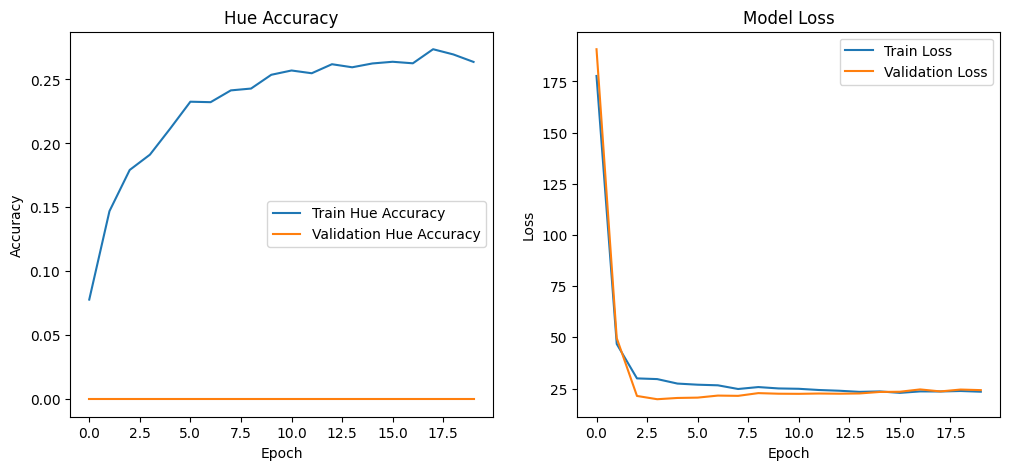

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['hue_output_accuracy'], label='Train Hue Accuracy')
plt.plot(history.history['val_hue_output_accuracy'], label='Validation Hue Accuracy')
plt.title('Hue Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()